Changelog:  (Last Updated 2023-03-09)

# Probabilistic ML: Assignment 3
- **Deadline**: 2023-03-27 (March 27th 2023)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    std = torch.exp(log_std)
    samples = mean + std * torch.randn(num_samples, mean.shape[0])

    return samples


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    std = torch.exp(log_std)
    return diag_gaussian_log_density(x, mean, std)

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    z = diag_gaussian_samples(mean, log_std, num_samples)
    log_pxz = logprob(z)
    log_qz = diag_gaussian_logpdf(z, mean, log_std)

    elbo = torch.mean(log_pxz - log_qz)
    return elbo


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  mean, logstd = params
  elbo = batch_elbo(log_posterior_A_beat_B_10_times_1_arg, mean, logstd, num_samples_per_iter)
  return -elbo

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Almost initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  9%|▉         | 72/800 [00:00<00:01, 717.81it/s]

Iteration 0 lower bound 10.281359672546387
Iteration 25 lower bound 6.369688510894775
Iteration 50 lower bound 6.69489860534668
Iteration 75 lower bound 5.77863883972168
Iteration 100 lower bound 4.9207611083984375
Iteration 125 lower bound 5.456614971160889


 35%|███▌      | 280/800 [00:00<00:00, 657.56it/s]

Iteration 150 lower bound 4.596118450164795
Iteration 175 lower bound 4.393908500671387
Iteration 200 lower bound 4.092942714691162
Iteration 225 lower bound 3.9666907787323
Iteration 250 lower bound 3.695132255554199
Iteration 275 lower bound 3.478168249130249


 52%|█████▏    | 412/800 [00:00<00:00, 650.12it/s]

Iteration 300 lower bound 3.3248131275177
Iteration 325 lower bound 3.259014844894409
Iteration 350 lower bound 2.984020948410034
Iteration 375 lower bound 2.9171876907348633
Iteration 400 lower bound 2.969562292098999
Iteration 425 lower bound 3.281099557876587


 69%|██████▉   | 550/800 [00:00<00:00, 667.84it/s]

Iteration 450 lower bound 2.972074270248413
Iteration 475 lower bound 2.9940240383148193
Iteration 500 lower bound 3.130434989929199
Iteration 525 lower bound 3.1351189613342285
Iteration 550 lower bound 2.930309534072876
Iteration 575 lower bound 2.8779985904693604


 85%|████████▌ | 683/800 [00:01<00:00, 572.67it/s]

Iteration 600 lower bound 2.868325710296631
Iteration 625 lower bound 2.9170420169830322
Iteration 650 lower bound 2.903447151184082
Iteration 675 lower bound 2.901132106781006


 93%|█████████▎| 743/800 [00:01<00:00, 517.58it/s]

Iteration 700 lower bound 2.826982021331787
Iteration 725 lower bound 3.009018898010254
Iteration 750 lower bound 2.783996343612671
Iteration 775 lower bound 2.8830296993255615


100%|██████████| 800/800 [00:01<00:00, 588.43it/s]


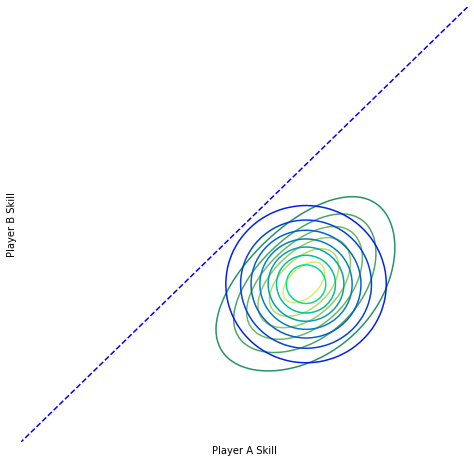

<Figure size 432x288 with 0 Axes>

In [ ]:
from pickle import TRUE
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2

init_mean = torch.zeros(D, requires_grad=True)
init_log_std = torch.zeros(D, requires_grad=True)

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

The final loss is around 2.88.

**d) [3pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    mean, log_std = params
    return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, mean, log_std,
                      num_samples_per_iter)

**e) [3pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

--- 

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


100%|██████████| 100/100 [00:00<00:00, 640.81it/s]

Iteration 0 lower bound 26.607376098632812
Iteration 25 lower bound 25.83322525024414
Iteration 50 lower bound 22.150915145874023
Iteration 75 lower bound 19.867937088012695


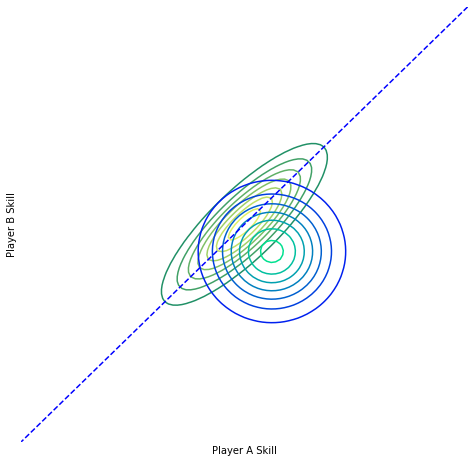

<Figure size 432x288 with 0 Axes>

In [ ]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

The final loss is around 19.86.

The joint settings of skills that A and B have the same skills will be
plausible under the true posterior, but are not plausible under the approximate posterior since the approximate posterior shows a little more tendency towards the Player A skill.

Changing the variational approximate posterior from a fully-factorized Gaussian to a non-factorized Gaussian will make a better approximation, since we can see from the plot that the true posterior has an oval shape which indicates the existence of covariance, but the fully-factorized assumes no covariance so the non-factorized Gaussian will make a better approximation.

## 1.2 [30 pts] Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
  mean, log_std = params
  zs = diag_gaussian_samples(mean, log_std, num_samples_per_iter)
  elbo = batch_elbo(log_joint_probability, mean, log_std, num_samples_per_iter)
  return -elbo

**c) [3pts]** Optimize, and report the final loss. 

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

Optimizing variational parameters...


  1%|          | 3/500 [00:00<00:20, 24.40it/s]

Iteration 0 lower bound 2301.15673828125


  6%|▌         | 31/500 [00:01<00:18, 25.23it/s]

Iteration 25 lower bound 2179.664794921875


 11%|█         | 54/500 [00:02<00:16, 27.02it/s]

Iteration 50 lower bound 2069.088623046875


 16%|█▌        | 81/500 [00:03<00:14, 28.33it/s]

Iteration 75 lower bound 1980.27587890625


 21%|██        | 103/500 [00:04<00:20, 19.05it/s]

Iteration 100 lower bound 1915.7664794921875


 26%|██▌       | 128/500 [00:05<00:26, 14.07it/s]

Iteration 125 lower bound 1860.1898193359375


 31%|███       | 154/500 [00:07<00:22, 15.44it/s]

Iteration 150 lower bound 1812.594970703125


 36%|███▌      | 178/500 [00:09<00:25, 12.51it/s]

Iteration 175 lower bound 1780.6630859375


 40%|████      | 202/500 [00:12<00:41,  7.20it/s]

Iteration 200 lower bound 1746.807861328125


 46%|████▌     | 231/500 [00:13<00:10, 24.78it/s]

Iteration 225 lower bound 1722.2474365234375


 51%|█████     | 254/500 [00:15<00:11, 22.02it/s]

Iteration 250 lower bound 1700.939697265625


 56%|█████▌    | 278/500 [00:16<00:11, 18.99it/s]

Iteration 275 lower bound 1682.246337890625


 60%|██████    | 302/500 [00:18<00:16, 11.96it/s]

Iteration 300 lower bound 1668.3570556640625


 65%|██████▌   | 327/500 [00:20<00:15, 10.96it/s]

Iteration 325 lower bound 1652.7022705078125


 71%|███████   | 354/500 [00:21<00:08, 16.65it/s]

Iteration 350 lower bound 1642.2169189453125


 75%|███████▌  | 377/500 [00:24<00:19,  6.22it/s]

Iteration 375 lower bound 1629.90771484375


 81%|████████  | 404/500 [00:27<00:06, 15.60it/s]

Iteration 400 lower bound 1620.8675537109375


 85%|████████▌ | 427/500 [00:28<00:05, 12.65it/s]

Iteration 425 lower bound 1611.4200439453125


 91%|█████████ | 454/500 [00:30<00:03, 13.97it/s]

Iteration 450 lower bound 1606.6129150390625


 96%|█████████▋| 482/500 [00:31<00:00, 26.93it/s]

Iteration 475 lower bound 1600.504638671875


100%|██████████| 500/500 [00:32<00:00, 15.39it/s]


The final loss is around 1600.

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

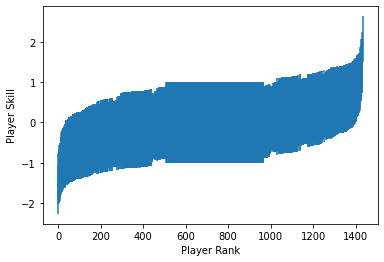

In [ ]:
mean_skills, logstd_skills = params[0].detach(), params[1].detach()

order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], torch.exp(logstd_skills)[order])

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
for i in range(1,11):
    print(names[order[-i]])

[1032 'doraemon61']
[311 'laode_syahril']
[640 'projetoxadrez']
[303 'mrzoom47']
[1431 'chesswithmom']
[841 'cdvh']
[1121 'hick4u1219']
[820 'smartduckduckcow']
[415 'sneaky_bugger']
[185 'lzchips']


**f) [3pt]** Plot samples from the joint posterior over the skills of lelik3310 and thebestofthebad. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

[496 'lelik3310']
[512 'thebestofthebad']


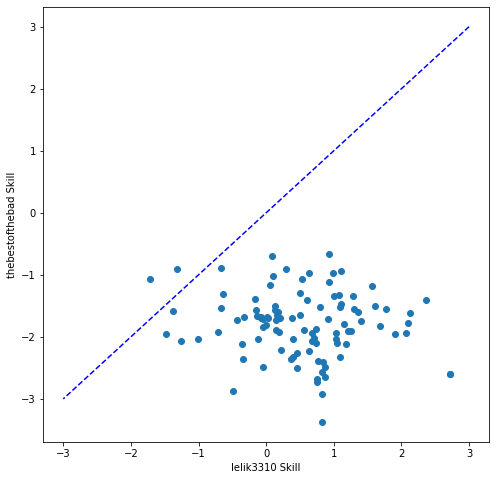

In [ ]:
lelik3310_ix = 496
thebestofthebad_ix = 512
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, lelik3310_ix], samples[:, thebestofthebad_ix])

From the plot, it seems like the skill of lelik3310 is better than the skill of thebestofthebad.

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim N (\mu, \Sigma)$, then $AX \sim  N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim N (\mu_i , \Sigma_{ii})$.

Your answer here.

\begin{align}
\text{To compute } p(z_A > z_B) \text{ We can compute } p(z_A - z_B >0) \\
\text{Since } \begin{bmatrix}
y_A\\
y_B
\end{bmatrix}
= \begin{bmatrix}
1 & -1\\
0 & 1
\end{bmatrix}
\begin{bmatrix}
z_A\\
z_B
\end{bmatrix} \\
\text{Therefore, let } Z = \begin{bmatrix}
z_A\\
z_B
\end{bmatrix}, 
Z \sim N (\mu, \Sigma), AZ \sim  N (A\mu, A\Sigma A^T), \text{where } \mu = \begin{bmatrix}
\mu_A\\
\mu_B
\end{bmatrix}, \Sigma = \begin{bmatrix}
\sigma_A ^2\\
\sigma_B ^2
\end{bmatrix}, A= \begin{bmatrix}
1 & -1\\
0 & 1
\end{bmatrix} \\
\implies AZ \sim  N (\begin{bmatrix}
\mu_A -\mu_B\\
\mu_B
\end{bmatrix}, \begin{bmatrix}
1 & -1\\
0 & 1
\end{bmatrix}\begin{bmatrix}
\sigma_A ^2 & 0\\
0 & \sigma_B ^2 
\end{bmatrix} \begin{bmatrix}
1 & 0\\
-1 & 1
\end{bmatrix})\\
\implies AZ \sim  N (\begin{bmatrix}
\mu_A -\mu_B\\
\mu_B
\end{bmatrix}, \begin{bmatrix}
\sigma_A ^2 + \sigma_B ^2 & -\sigma_B ^2 \\
-\sigma_B ^2  & \sigma_B ^2 
\end{bmatrix}), \text{ Therefore } z_A - z_B \sim  N(\mu_A -\mu_B, \sigma_A ^2 + \sigma_B ^2).\\
p(z_A - z_B > 0) = 1- p(z_A - z_B \le 0) = 1-\Phi(\frac{\mu_B -\mu_A}{\sqrt{\sigma_A ^2 + \sigma_B ^2}}).
\end{align}

**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    mu_A = mean_skills[A_ix]
    mu_B = mean_skills[B_ix]
    var_A = torch.exp(2*logstd_skills[A_ix])
    var_B = torch.exp(2*logstd_skills[B_ix])
    formula_est = torch.distributions.Normal(0, 1).cdf((mu_A - mu_B) / torch.sqrt(var_A + var_B))
    # Simple Monte Carlo estimate
    samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
    mc_est = (samples[:, A_ix] > samples[:, B_ix]).float().mean()

    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")


Exact CDF Estimate: 0.9864164590835571
Simple MC Estimate: 0.9857000112533569


**i) [2pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
fifth_worst_ix = order[4]

exact_probability, mc_probability = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact probability: {exact_probability}")
print(f"Monte Carlo estimate: {mc_probability}")

Exact probability: 0.9636213779449463
Monte Carlo estimate: 0.9592999815940857


**j) [3 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?


Your answer here.\
No.


**k) [3 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.

I think HMC from HW2 can produce a better overall approximation to the true posterior over all skills conditioned on all games. A simple approximate posterior (like a Gaussian) may not suit for the true posterior distribution, but HMC can produce a more similar distribution to the true posterior.